Make sure the tf version is 2.5.0-dev20201111 or later (for model saving)

In [6]:
#!pip install tf-nightly -qqq --progress-bar off
import tensorflow as tf
print(tf.__version__)
#assert tf.__version__== '2.5.0-dev20201111','bad version'

2.5.0-dev20201123


In [39]:
from datetime import datetime;now = datetime.now;t00 = now()
print(t00)

2020-11-23 15:07:32.964836


In [12]:
pwd

'/gsfs0/data/aglinsai/BC-MRI-AE/Colab Notebooks'

In [40]:
%matplotlib inline

import os
from matplotlib import pyplot as plt
import seaborn as sns

import numpy as np
import pandas as pd
from tqdm import tqdm

#from contrastive_vae.celeb_utils import get_celeb_vae
#from contrastive_vae.celeb_utils import get_celeb_cvae

import pandas as pd
from sklearn.metrics import silhouette_score

from mri_utils import get_MRI_CVAE_3D,get_MRI_CCVAE_3D

print(now()-t00)

0:00:34.577685


In [15]:
cd ../

/gsfs0/data/aglinsai/BC-MRI-AE


SHAPE THE DATA

In [16]:
arr = np.load('./Data/ABIDE-Anat-64iso.npz')
ABIDE_data = arr['data']
ABIDE_subs = arr['subs']
nsubs = ABIDE_data.shape[0]
[arr.shape for arr in [ABIDE_subs,ABIDE_data]]

[(1022,), (1022, 64, 64, 64)]

In [17]:
aa = np.array([ABIDE_data[s,:,:,:].sum() for s in range(ABIDE_data.shape[0])])<5000
ABIDE_data = ABIDE_data[~aa,:,:,:]
ABIDE_subs = ABIDE_subs[~aa]
[arr.shape for arr in [ABIDE_subs,ABIDE_data]]

[(982,), (982, 64, 64, 64)]

In [19]:
df = pd.read_csv('./CSVs/ABIDE-legend.csv',header=0)
df = df.iloc[np.array([df['BIDS_ID'].values[s] in ABIDE_subs for s in range(len(df))])]
df.reset_index(inplace=True)

assert len(df)==len(ABIDE_subs),'dif lenghts'
assert all([df['BIDS_ID'][s]==ABIDE_subs[s] for s in range(len(df))]),'mismatch between df and goodsubs'

df.head(5)

,index,BIDS_ID,Anonymized ID,Subject Type,Visit,Days since enrollment,SubID,DxGroup,DSMIVTR,AgeAtScan,...,WISC4 Pic Con Scaled,WISC4 Matrix Scaled,WISC4 Dig Span Scaled,WISC4 Let Num Scaled,WISC4 Coding Scaled,WISC4 Sym Scaled,Age at MPRAGE,Current Med Status,Medication Name,Off stimulants at EPI scan?
0,0,sub-001,A00033348,PATIENT,session_1,8,51320,1,2,31.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN
1,1,sub-002,A00033398,CONTROL,session_1,8,51373,2,0,46.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN
2,2,sub-003,A00033352,PATIENT,session_1,8,51324,1,2,52.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN
3,3,sub-004,A00033389,CONTROL,session_1,8,51364,2,0,26.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN
4,4,sub-005,A00033354,PATIENT,session_1,8,51326,1,2,42.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN


In [22]:
TD_subs = ABIDE_data[np.array(df['Subject Type']=='CONTROL'),:,:,:]
DX_subs = ABIDE_data[np.array(df['Subject Type']=='PATIENT'),:,:,:]

print(TD_subs.shape)
print(DX_subs.shape)

(500, 64, 64, 64)
(456, 64, 64, 64)


In [25]:
dxArr = np.ones(len(df))
dxArr[np.array(df['Subject Type']=='PATIENT')]=2

TRAIN THE VAE

In [45]:
from scipy.spatial.distance import pdist
from scipy.spatial.distance import squareform

def plot_state_cvae():
    plt.figure(figsize=(12,5))
    plt.subplot(1,3,1)
    plt.imshow(vae.predict(TD_batch)[0,32,:,:,0])
    plt.subplot(1,3,2)
    plt.imshow(decoder.predict(np.random.randn(3,2))[0,32,:,:,0])
    plt.subplot(1,3,3)
    arr = encoder.predict(ABIDE_data)[2]
    plt.scatter(arr[:,0],arr[:,1],c=dxArr)

In [46]:
#encoder, decoder, vae = get_MRI_CVAE_3D(input_shape=(64, 64, 64, 1), latent_dim=2, batch_size=32, disentangle=False, gamma=1)
#vae.load_weights('../tf_outputs/weights/lol')

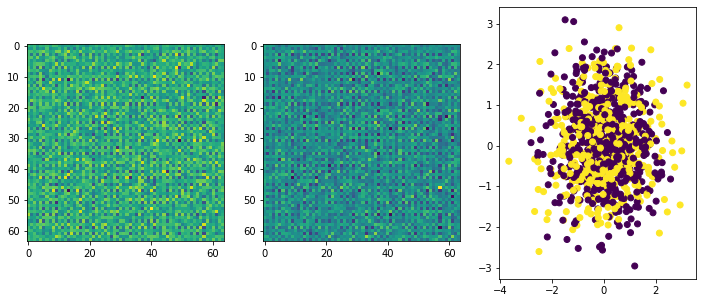

In [47]:
#plot_state_cvae()

# TRAIN THE CONTRASTIVE VAE

In [85]:
latent_dim = 8
cvae, cvae_fg, z_encoder, z_encoder, cvae_decoder = get_MRI_CCVAE_3D(latent_dim=latent_dim)
#cvae.load_weights('../tf_outputs/3D_CCVAE_Weights/lol')

In [89]:
def plot_state_ccvae(latent_dim):
    plt.figure(figsize=(12,5))
    plt.subplot(1,3,1)
    plt.imshow(cvae.predict([TD_batch,TD_batch])[0][0,32,:,:,0])
    plt.subplot(1,3,2)
    plt.imshow(cvae_decoder.predict(np.random.randn(3,latent_dim*2))[0,32,:,:,0])
    plt.subplot(1,3,3)
    arr = z_encoder.predict(ABIDE_data)[2]
    plt.scatter(arr[:,0],arr[:,1],c=dxArr)

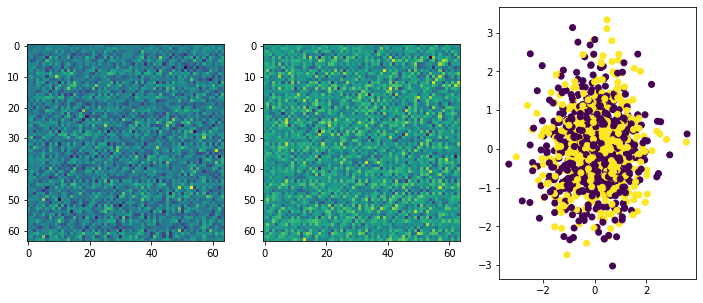

In [91]:
plot_state_ccvae(latent_dim)

started: 2020-11-23 15:39:31.141539
1/1 [==============================] - 16s 16s/step - loss: 107782.7031
epoch time: 0:00:17.726645, elapsed time: 0:00:17.727183


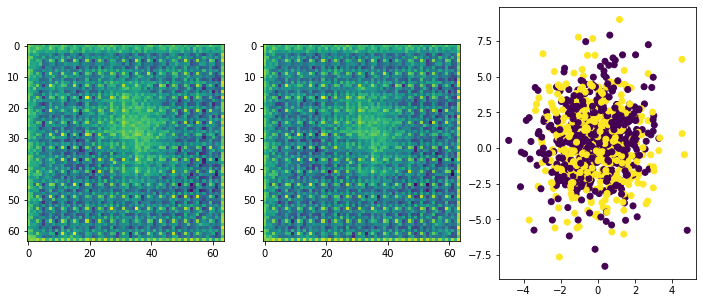

1/1 [==============================] - 16s 16s/step - loss: 101218.2812
epoch time: 0:00:17.608819, elapsed time: 0:00:56.668116
done in: 0:00:56.668842


In [94]:
t0 = now()
print(f'started: {now()}')
for i in range(2):
    e0 = now()
    hist = cvae.fit([DX_batch,TD_batch],epochs=1)
    cvae.save_weights('../tf_outputs/3D_CCVAE_Weights/Nov23')
    print(f"epoch time: {now()-e0}, elapsed time: {now()-t0}")
    
    if np.mod(i,25)==0:
        plot_state_ccvae(latent_dim)
        plt.show()
        
print(f'done in: {now()-t0}')